# Introduction: Business Problem 

In this project we will try to predict the monthly rental price for a condominium. Specifically, this report will be targeted to stakeholders interested in finding the best value in renting a condominium in Singapore.

We will use our data science powers to find optimum rental price and recommend stake holders the best values and similar units for the stakeholders.

# Important & Settings

In [223]:
#!pip install feature_engine

In [224]:
import pandas as pd
import numpy as np
from IPython.display import display

from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.encoding import RareLabelEncoder

from sklearn.feature_extraction.text import CountVectorizer


import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy import stats

import folium
from folium.plugins import MarkerCluster
import branca.colormap as cmp

import geojson

import seaborn as sns

In [225]:
#pandas setting
pd.set_option('max_columns', None)

#global rng
rng = np.random.RandomState(1)

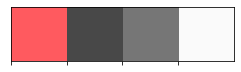

In [226]:
#colour template

pink = '#FF5A5F'
light_black = '#484848'
grey = '#767676'
background_color = "#fafafa"
face_color = '#fafafa'

sns.palplot([pink, light_black, grey, background_color])

# Exploratory Data Analysis

In [227]:
df_train = pd.read_csv('Data/df_train.csv')
df_train.head(2)

,detailed_address,lat,long,bedrooms,bathrooms,price_sqft,built_year,amenities,mrt_name,building_name,tenure,link,picture_url,price_month,walking_time,distance,studio,district_number
0,61 Cairnhill Circle,1.306633,103.839969,2.0,2.0,4.65,2015.0,"['Lounge', 'Bomb shelter', 'Renovated', 'Airco...",Newton MRT,The Peak @ Cairnhill II,1,https://www.99.co/singapore/rent/property/the-...,https://www.99.co/static/v3/icons/lounge@3x.png,4200,10.0,482.0,0,9
1,31 Jalan Rama Rama,1.327227,103.849149,3.0,3.0,3.04,2006.0,"['Badminton court', 'Adventure park', 'Gym', '...",Toa Payoh MRT,De Royale,1,https://www.99.co/singapore/rent/property/de-r...,https://www.99.co/static/v3/icons/badminton_ha...,3900,15.0,1021.0,0,12


# Creating Sqrt Feature

## Categorical Data

### Amenities

We will first investigate if there is a price different in terms of number of amenities count

In [228]:
df_train['amenities_count'] = df_train.amenities.apply(lambda x: len(x))

Text(0.5, 1.0, 'Amenities Count vs Price')

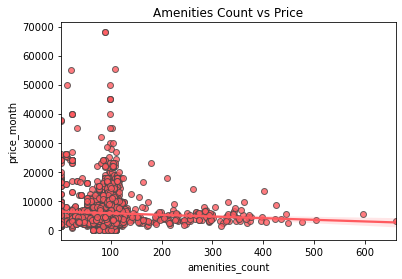

In [229]:
sns.regplot(
        x=df_train['amenities_count'],
        y=df_train['price_month'],
        color=pink,
        scatter_kws = {"edgecolor": light_black}
        )
plt.title('Amenities Count vs Price');

There is no clear correlation between number of amenities and the rental price.

In [230]:
countvec = CountVectorizer()
dtm = countvec.fit_transform(df_train.amenities)

In [231]:
df_eda = pd.DataFrame(dtm.toarray(), columns=countvec.get_feature_names())
# ensure each amenities only count once in each listing
for col in df_eda.columns:
    df_eda[col] = np.where(df_eda[col] > 1, 1, df_eda[col])

#introduce price_month for groupby
df_eda['price_month'] = df_train['price_month'].values

In [232]:
#Amenities with more than 30%.
amenities_weightages = (df_eda.sum() / len(df_eda)*100).sort_values(ascending=False).iloc[1:10]
amenities_weightages

pool         79.092136
gym          62.740466
swimming     46.692541
clubhouse    43.891326
parking      43.300709
jacuzzi      42.895714
room         33.226460
security     32.332096
wading       30.458994
dtype: float64

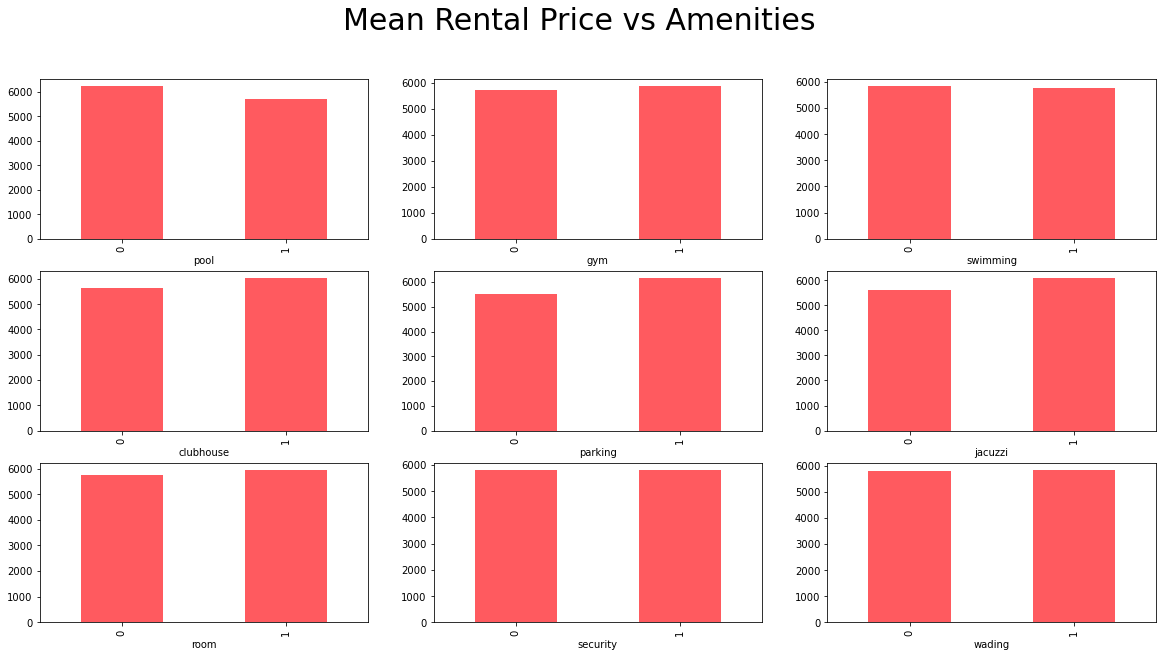

In [233]:
nrows = 3
ncols = 3
index = 0
feature = amenities_weightages.index
fig, ax = plt.subplots(nrows = nrows, ncols= ncols, figsize=(20,10))

for row in range(nrows):
    for col in range(ncols):
        
        #barplot for price
        df_eda.groupby(feature[index])['price_month'].mean().plot.bar(ax=ax[row][col], color=pink)
        index += 1
        
fig.suptitle("Mean Rental Price vs Amenities", fontsize='30');


From above, we can see that for gym, clubhouse , jaccuzi, parking there is a  slight difference in terms of mean price.
we can do a hypothesis test to check if the mean price is significant.

In [234]:
def mean_ttest(feature, a, b, significant_level = 0.05):
    z, p = stats.ttest_ind(a, b)
    if p < significant_level:
        state = 'Null Hypothesis Rejected'
    else:
        state = 'Fail to reject Null Hypothesis'
        
    print('******************************')
    print(feature)
    print(state)
    print('p-value', p)
    return state

Null Hypothesis : there is no difference between the mean price of having/not having the amenities.

Alternate Hypothesis : reject the null hypothesis, there is a difference.

In [235]:
amenities =  []
for amenity in feature:
    no = df_eda.loc[df_eda[amenity] == 0, 'price_month']
    yes = df_eda.loc[df_eda[amenity] == 1, 'price_month']
    state = mean_ttest(amenity, no, yes)
    if state == 'Null Hypothesis Rejected':
        amenities.append(amenity)
        
    

******************************
pool
Null Hypothesis Rejected
p-value 0.00018355208730501906
******************************
gym
Fail to reject Null Hypothesis
p-value 0.29861896679495187
******************************
swimming
Fail to reject Null Hypothesis
p-value 0.702194898053948
******************************
clubhouse
Null Hypothesis Rejected
p-value 0.0008680968765662284
******************************
parking
Null Hypothesis Rejected
p-value 1.2182764890545857e-07
******************************
jacuzzi
Null Hypothesis Rejected
p-value 5.054184737399292e-05
******************************
room
Fail to reject Null Hypothesis
p-value 0.10835501923462228
******************************
security
Fail to reject Null Hypothesis
p-value 0.9968370783883909
******************************
wading
Fail to reject Null Hypothesis
p-value 0.8142789146219934


In [236]:
amenities

['pool', 'clubhouse', 'parking', 'jacuzzi']

**Feature Engineering**: For Amenities, we will one hot encode these as feature which is significant while other amenities as Others

### MRT_Name

In [237]:
def plotcardinality(df, variable, perc):
    plt.figure(figsize=(20,5))
    temp_df = df[variable].value_counts(normalize=True)
    fig = temp_df.sort_values(ascending=False).plot.bar(color='pink')

    # add a line at .5 % to flag the threshold for rare categories
    fig.axhline(y=perc/100, color='blue')
    fig.set_ylabel('Percentage of Mrt')
    return plt

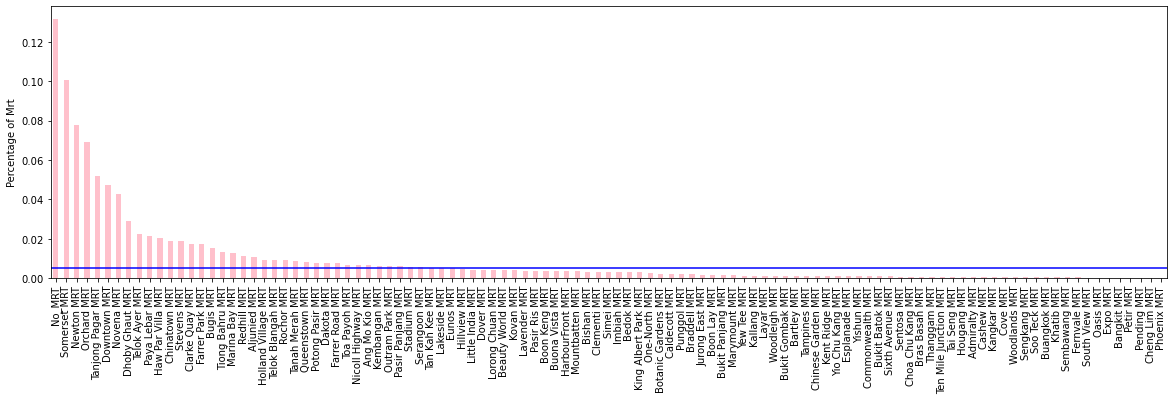

In [238]:
plotcardinality(df_train, 'mrt_name', perc= 0.5);

MRT featuere shows high cardinality. Grouping categories into rare for variables with high cardinality, tends to improve model performance and to smooth model deployment.



In [239]:
rare_encoder = RareLabelEncoder(
    tol=0.005,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['mrt_name'] # variables to re-group
)

In [240]:
df_temp = rare_encoder.fit_transform(df_train)

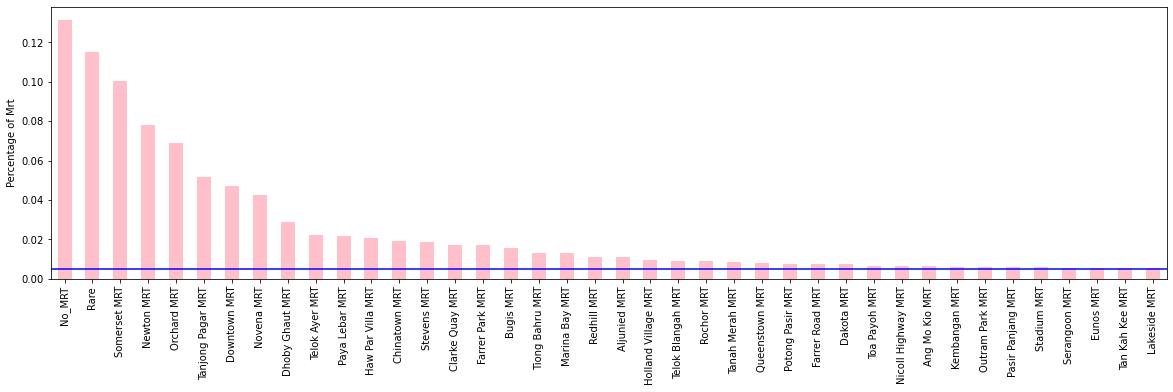

In [241]:
plotcardinality(df_temp, 'mrt_name', perc=0.5);

**Feature Engineering**
1. Use Rare Label to encode MRT with low occurance into rare
2. OneHotEncode all above results

# Building Name

In [242]:
df_train.building_name.unique().shape[0]

1089

building name has extremely high cardinality. With only 5000 training set, this will expand the feature space to 1095 columns if we decide to one hot encode it. Instead, lets find out if there is any building that has higher mean average price

In [243]:
# average median price
y_med = df_train.price_month.median()
y_med

4500.0

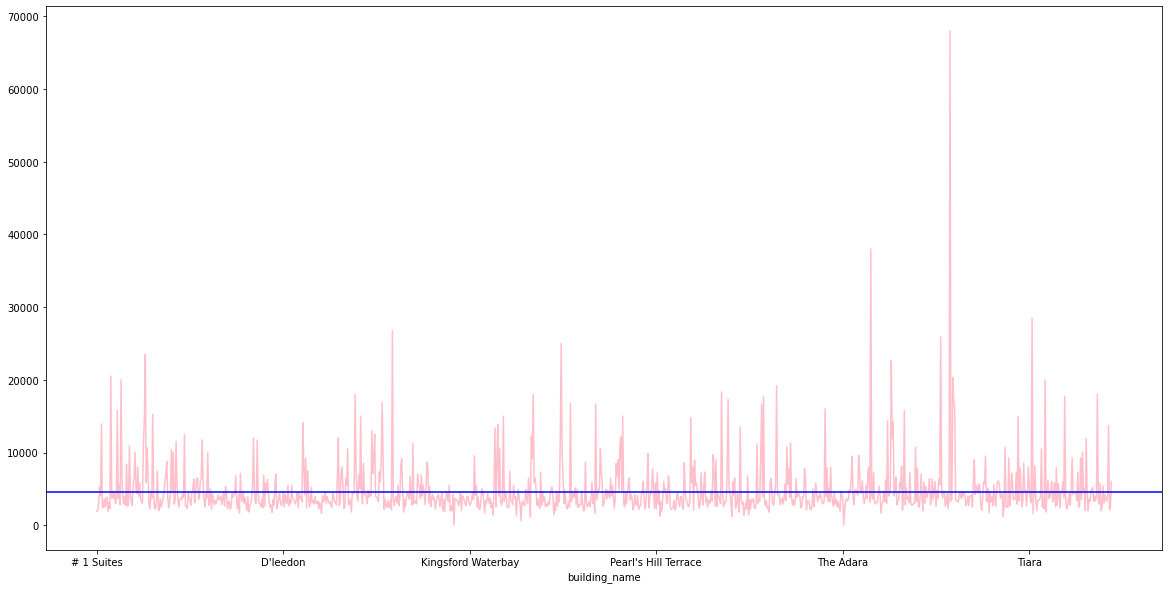

In [244]:
plt.figure(figsize=(20,10))
ax = df_train.groupby(['building_name']).price_month.mean().plot(color='pink')
ax.axhline(y=y_med, color='blue')

# District_number

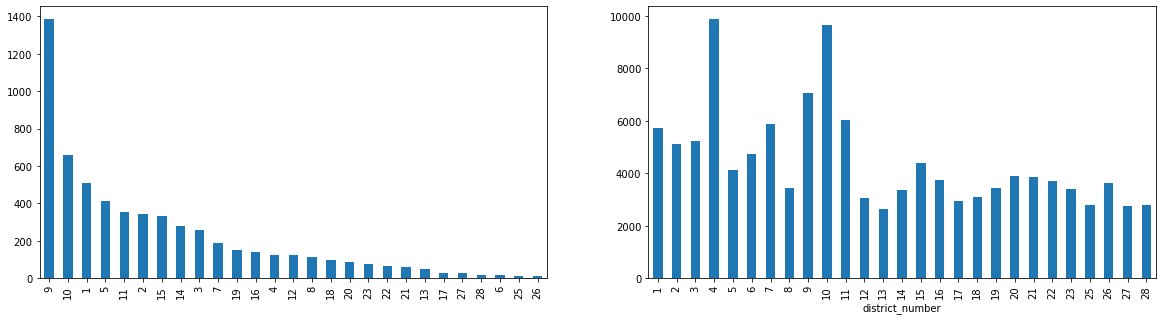

In [245]:
nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows = nrows, ncols= ncols, figsize=(20,5))
df_train.district_number.value_counts().plot.bar(ax=ax[0])
df_train.groupby('district_number')['price_month'].mean().plot.bar(ax=ax[1]);


In [247]:
with open("Data/singapore.geojson") as f:
    gj = geojson.load(f)
    singapore_lat = 1.290270
    singapore_lng = 103.851959
    
    # create a dataframe of district number vs rental per month
    df_temp = df_train.groupby('district_number')['price_month'].mean().reset_index()

    
    #important must be str type to match geojson
    df_temp['district_number']=df_temp['district_number'].astype(str)
    
    #bins for price_month
    bins = (df_temp["price_month"].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
    
    map_singapore = folium.Map(location=(singapore_lat,singapore_lng), zoom_start=11,tiles=None)
    folium.TileLayer('Stamen Terrain',name="Light Map",control=False).add_to(map_singapore)
    choropleth = folium.Choropleth(
        geo_data=gj,
        data=df_temp,
        name = 'Mean Rental Price',
        columns=['district_number', 'price_month'],
        key_on='feature.properties.id',
        fill_color="BuPu",
        fill_opacity=0.9,
        line_opacity=1,
        bins = bins,
        legend_name = 'Quantile of Mean Condominium Monthly Rental Price',
        highlight=True,
        show=True,
        nan_fill_color = "black"
        ).add_to(map_singapore)
    
    NIL = folium.features.GeoJsonTooltip(['id'], labels=True)
    choropleth.geojson.add_child(NIL)
    map_singapore.keep_in_front(NIL)
    folium.LayerControl().add_to(map_singapore)
    
map_singapore

In [248]:
df_train.groupby(['lat', 'long'])['built_year']

,detailed_address,lat,long,bedrooms,bathrooms,price_sqft,built_year,amenities,mrt_name,building_name,tenure,link,picture_url,price_month,walking_time,distance,studio,district_number,amenities_count
0,61 Cairnhill Circle,1.306633,103.839969,2.0,2.0,4.65,2015.0,"['Lounge', 'Bomb shelter', 'Renovated', 'Airco...",Newton MRT,The Peak @ Cairnhill II,1,https://www.99.co/singapore/rent/property/the-...,https://www.99.co/static/v3/icons/lounge@3x.png,4200,10.0,482.0,0,9,96
1,31 Jalan Rama Rama,1.327227,103.849149,3.0,3.0,3.04,2006.0,"['Badminton court', 'Adventure park', 'Gym', '...",Toa Payoh MRT,De Royale,1,https://www.99.co/singapore/rent/property/de-r...,https://www.99.co/static/v3/icons/badminton_ha...,3900,15.0,1021.0,0,12,114
2,60 Havelock Road,1.287943,103.842739,4.0,4.0,2.88,2000.0,"['Clubhouse', 'Bomb shelter', 'Fitness corner'...",Chinatown MRT,River Place,0,https://www.99.co/singapore/rent/property/rive...,https://www.99.co/static/v3/icons/clubhouse@3x...,10500,20.0,1583.0,0,3,104
3,23 Jalan Rajah,1.327526,103.852424,1.0,1.0,5.44,2012.0,"['Gym', 'Pool deck', 'Swimming pool', 'Wading ...",Toa Payoh MRT,The Verve,1,https://www.99.co/singapore/rent/property/the-...,https://www.99.co/static/v3/icons/gym@3x.png,2400,10.0,552.0,0,12,100
4,6 Marina Boulevard,1.278053,103.858379,2.0,2.0,6.63,2008.0,"['Jogging track', 'Clubhouse', 'Function room'...",Downtown MRT,The Sail @ Marina Bay,0,https://www.99.co/singapore/rent/property/the-...,https://www.99.co/static/v3/icons/jogging_trac...,6200,5.0,216.0,0,1,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5921,136B Hillview Avenue,1.362120,103.764701,3.0,3.0,2.60,1999.0,"['Clubhouse', 'Stove', 'Walk in closet', 'Squa...",Bukit Gombak MRT,Merawoods,0,https://www.99.co/singapore/rent/property/mera...,https://www.99.co/static/v3/icons/clubhouse@3x...,3500,30.0,3568.0,0,23,103
5922,60 Marine Parade Road,1.306676,103.914698,2.0,2.0,3.52,2004.0,"['Jogging track', 'Clubhouse', 'Water feature'...",No_MRT,Cote D'azur,0,https://www.99.co/singapore/rent/property/cote...,https://www.99.co/static/v3/icons/jogging_trac...,3900,35.0,5169.0,0,15,105
5923,16 Mount Elizabeth,1.305210,103.835920,2.0,3.0,4.89,2010.0,"['High ceiling', 'Stove', 'Jacuzzi', 'Oven', '...",Orchard MRT,Rhapsody On Mount Elizabeth,1,https://www.99.co/singapore/rent/property/rhap...,https://pic.99.co/v3/TCs7kczW8y6bE73YiSZDe3?wi...,5100,10.0,491.0,0,9,373
5924,34 West Coast Road,1.311631,103.756602,3.0,3.0,4.57,2008.0,"['Clubhouse', 'Gym', 'Swimming pool', 'Wading ...",No_MRT,Varsity Park Condominium,0,https://www.99.co/singapore/rent/property/vars...,https://www.99.co/static/v3/icons/clubhouse@3x...,6000,35.0,5169.0,0,5,96


https://towardsdatascience.com/using-folium-to-generate-choropleth-map-with-customised-tooltips-12e4cec42af2